In [2]:
!pip3 install pmdarima
!pip3 install keras
!pip3 install statsmodels
!pip install seaborn

^C


In [504]:
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

import pandas

In [3]:
import numpy as np
import pandas as pd

from pmdarima.arima import auto_arima

from keras.models import Sequential
from keras.layers import Dense, LSTM, Dropout

C:\Users\13127\anaconda3\lib\site-packages\pandas\core\computation\expressions.py:21: UserWarning: Pandas requires version '2.7.3' or newer of 'numexpr' (version '2.7.1' currently installed).
  from pandas.core.computation.check import NUMEXPR_INSTALLED


In [539]:
SPY_df = pd.read_csv ('SPY.csv')
SPY_df['Date'] = pd.to_datetime(SPY_df['Date'],format="%Y-%m-%d")

graph_df = SPY_df.copy()
graph_df.set_index(['Date'],inplace=True)

plt_df = graph_df.groupby([graph_df.index.month,graph_df.index.year]).sum()

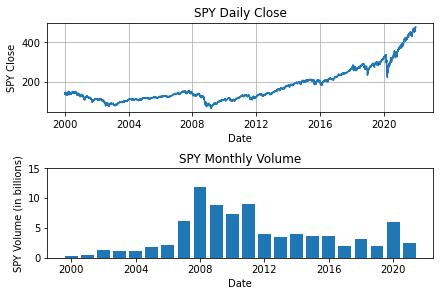

In [544]:
# Figure 1

import matplotlib.pyplot as plt

figure, axis = plt.subplots(2, 1,constrained_layout=True)


axis[0].plot(SPY_df['Date'], SPY_df['Close'])
axis[0].set_xlabel('Date')
axis[0].set_ylabel('SPY Close')
axis[0].set_title('SPY Daily Close')
axis[0].grid()

axis[1].bar([i[1] for i in plt_df.index],[int(val)/10**9 for val in plt_df['Volume']])
axis[1].set_ylim([0, 15])
axis[1].set_xticks([2000 + 4*i for i in range(6)])
axis[1].set_title('SPY Monthly Volume')
axis[1].set_ylabel('SPY Volume (in billions)')
axis[1].set_xlabel('Date')
axis[1].ticklabel_format(useOffset=False)

plt.show()

In [6]:
train = SPY_df.head(4982)
test = SPY_df.tail(554)

train_tune = train.head(4483)
train_valid = train.tail(499)

In [ ]:
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.stattools import adfuller

def find_arma(train_tune_df,train_valid_df,input_parmas,adf_thres=0.05):
    
    param_res_dt = {}
    pick_dt = {}

    for params_comb in input_parmas:
        valid_miss = []
        train_miss = []

        valid_APE_miss = []
        train_APE_miss = []

        for i in range(len(train_valid_df)):
            use_data = list(train_tune_df['Close'][i:]) + list(train_valid_df['Close'][0:i])
            
            no_diff = adfuller(use_data)
            if no_diff[1] > adf_thres:
                diff = adfuller(np.diff(use_data))
                if diff[1] > adf_thres:
                    print('issue at i:' + i)
                    break
                if diff[1] > adf_thres:
                    d = 1
            else:
                d = 0
            
            curr_model = ARIMA(use_data, order=(params_comb[0],d,params_comb[2]))
            curr_model_fit = curr_model.fit()

            valid_miss.append(curr_model_fit.forecast() - list(train_valid_df['Close'])[i])
            train_miss.append(curr_model_fit.mse)

            valid_APE_miss.append(abs(curr_model_fit.forecast() - list(train_valid_df['Close'])[i])/abs(list(train_valid_df['Close'])[i]))
            train_APE_miss.append(np.mean(abs(np.array(curr_model_fit.fittedvalues[1:]) - np.array(use_data[1:]))/abs(np.array(use_data[1:]))))

        param_res_dt[params_comb] = [np.mean([miss_val**2 for miss_val in valid_miss]),np.mean(train_miss),np.mean(valid_APE_miss),np.mean(train_APE_miss)]
        pick_dt[params_comb] = np.mean([miss_val**2 for miss_val in valid_miss])
        
        return min(pick_dt, key=pick_dt.get)
    

In [ ]:
from statsmodels.tsa.arima.model import ARIMA

import itertools
input_params = [[0,1,2],[0,1,2]]
params_combs = list(itertools.product(*input_params))

param_res_dt = {}

for params_comb in params_combs:
    valid_miss = []
    train_miss = []
    
    valid_APE_miss = []
    train_APE_miss = []
    
    len(train_valid)
    
    for i in range(len(train_valid)):
        print(i)
        use_data = list(train_tune['Close'][i:]) + list(train_valid['Close'][0:i])
        curr_model = ARIMA(use_data, order=(params_comb[0],params_comb[1],params_comb[2]))
        curr_model_fit = curr_model.fit()
        
        valid_miss.append(curr_model_fit.forecast() - list(train_valid['Close'])[i])
        train_miss.append(curr_model_fit.mse)
        
        valid_APE_miss.append(abs(curr_model_fit.forecast() - list(train_valid['Close'])[i])/abs(list(train_valid['Close'])[i]))
        train_APE_miss.append(np.mean(abs(np.array(curr_model_fit.fittedvalues[1:]) - np.array(use_data[1:]))/abs(np.array(use_data[1:]))))
        
    param_res_dt[params_comb] = [np.mean([miss_val**2 for miss_val in valid_miss]),np.mean(train_miss),np.mean(valid_APE_miss),np.mean(train_APE_miss)]
    print(params_comb)

In [ ]:
from statsmodels.tsa.stattools import adfuller

no_diff = []
diff = []

for i in range(len(train_valid)):
    use_data = np.array(list(train_tune['Close'][i:]) + list(train_valid['Close'][0:i]))
    y = adfuller(use_data)
    no_diff.append(y[1])
    x = adfuller(np.diff(use_data))
    diff.append(x[1])

In [ ]:
param_res_df = pd.DataFrame({'Parameters':[list(param_res_dt.keys())][0],'Val. MSE':[param_res_dt[i][0] for i in param_res_dt],'Train MSE':[param_res_dt[i][1] for i in param_res_dt],'Val. MAPE':[param_res_dt[i][2] for i in param_res_dt]})

In [ ]:
param_res_df['MSE change'] = param_res_df['Val. MSE']/param_res_df['Train MSE']
param_res_df['Val. MSE'] = param_res_df['Val. MSE'].round(2)
param_res_df['Train MSE'] = param_res_df['Train MSE'].round(2)

param_res_df['MSE change'] = param_res_df['MSE change'].round(3).astype(str) + 'x'

param_res_df['Val. MAPE'] = param_res_df['Val. MAPE'] * 100

param_res_df['Val. MAPE'] = param_res_df['Val. MAPE'].round(3).astype(str) + '%'

param_res_df[['Parameters','Val. MSE','Train MSE','Val. MAPE']]

In [ ]:
# Figure 2

from mpl_toolkits import mplot3d
fig = plt.figure()
ax = plt.axes(projection='3d')

zline = [row for row in param_res_df['Val. MSE']]
xline = [row[0] for row in param_res_df['Parameters']]
yline = [row[2] for row in param_res_df['Parameters']]

ax.plot(xline, yline, zline, c='blue',label='traversed')
ax.set_xlabel('p')
ax.set_ylabel('q')
ax.set_zlabel('Validation Set MSE', rotation=90)

ax.scatter3D(2, 0, 6.65223, c='red', marker = 'v',label='lowest MSE')

ax.legend()

ax.azim, ax.elev = 300,20

In [11]:
import keras
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense
import tensorflow.keras.layers as layers

In [280]:
LSTM_tries = [[5,5],[10,10],[25,25],[50,50],[100,100]]

In [ ]:
res_try_raw_d_0 = auto_LSTM(train_tune, train_valid, LSTM_tries + [[500,500],[1000,1000]],only_val=False,raw=True)

training:[5, 5] window_size=5
Epoch 1/5
140/140 [==============================] - 3s 5ms/step - loss: 21708.7324 - mean_squared_error: 21708.7324
Epoch 2/5
140/140 [==============================] - 1s 5ms/step - loss: 21556.5547 - mean_squared_error: 21556.5547
Epoch 3/5
140/140 [==============================] - 1s 5ms/step - loss: 21444.3242 - mean_squared_error: 21444.3242
Epoch 4/5
140/140 [==============================] - 1s 5ms/step - loss: 21334.2969 - mean_squared_error: 21334.2969
Epoch 5/5
16/16 [==============================] - 0s 3ms/step
[5, 5] window_size=5 train_score: 17529.66427349043
[5, 5] window_size=5 val_score: 256.91094712754966
training:[10, 10] window_size=10
Epoch 1/5
140/140 [==============================] - 3s 7ms/step - loss: 21852.5703 - mean_squared_error: 21852.5703
Epoch 2/5
140/140 [==============================] - 1s 7ms/step - loss: 21457.9121 - mean_squared_error: 21457.9121
Epoch 3/5
140/140 [==============================] - 1s 7ms/step - lo

In [394]:
#Item 3

def windowing(series, window):
    X, Y = list(), list()
    for i in range(len(series)):
        take_rng = i + window
        if take_rng > len(series) - 1:
            break
        x, y = series[i:take_rng], series[take_rng]
        X.append(x)
        Y.append(y)

    return np.array(X), np.array(Y)

def standardize(series,mean=None,sd=None):
    if (mean == None) and (sd == None):
        mean = np.mean(series)
        sd = (np.var(series))**0.5
        return (series - mean)/sd,mean,sd

    else:
        return (series - mean)/sd,mean,sd


def auto_LSTM(train_tune_df, train_valid_df,
             LSTM_setup = LSTM_tries, epochs_size = 5, h = 1, d = None,\
             only_val=True,drop_rate = None,raw = False):

    if d == None:
        
        res_dict = dict()
        
        for LSTM_setup_comb in LSTM_setup:
            
            num_neurons = LSTM_setup_comb[0]
            window = LSTM_setup_comb[1]
            
            train, train_mu, train_sigma = standardize(train_tune_df.reset_index()['Close'])
            val, _ , _ = standardize(train_valid_df.reset_index()['Close'], mean = train_mu, sd = train_sigma)

            X, Y = windowing(train, window)

            use_val = np.array(list(train)[-window:] + list(val))
            X_val, Y_val = windowing(use_val, window)

            x_raw_train, y_raw_train = windowing(train_tune_df.reset_index()['Close'],window)

            use_raw = np.array(list(train_tune_df.reset_index()['Close'])[-window:] + list(train_valid_df.reset_index()['Close']))
            x_raw_val, y_raw_val = windowing(use_raw,window)
            
            curr_model = keras.Sequential()
            
            curr_model.add(layers.LSTM(num_neurons, input_shape=(window, h),return_sequences=False))
            
            if drop_rate != None:
                curr_model.add(Dropout(drop_rate))

            curr_model.add(layers.Dense(1))
            curr_model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
            print("training:" + str(LSTM_setup_comb) + ' window_size=' + str(window))
            
            if raw == True:
                X, Y = x_raw_train,y_raw_train
                X_val, Y_val = x_raw_val,y_raw_val
            
            curr_model.fit(X, Y, epochs=epochs_size)

            train_pred = np.array([i[0] for i in (curr_model.predict(X) * train_sigma) + train_mu])
            train_score = np.mean((train_pred - y_raw_train)**2)
            train_MAPE = np.mean(abs(np.array(train_pred - y_raw_train))/abs(np.array(y_raw_train)))*100

            val_pred = np.array([i[0] for i in (curr_model.predict(X_val) * train_sigma) + train_mu])
            val_score = np.mean((val_pred - y_raw_val)**2)
            val_MAPE = np.mean(abs(np.array(val_pred - y_raw_val))/abs(np.array(y_raw_val)))*100

            if only_val == True:
                res_dict[str(LSTM_setup_comb) + ' window_size=' + str(window)] = val_score
            if only_val == False:
                res_dict[str(LSTM_setup_comb) + ' window_size=' + str(window)] = [val_score,train_score,val_MAPE,train_MAPE]

            print(str(LSTM_setup_comb) + ' window_size=' + str(window) + " train_score: " + str(train_score))
            print(str(LSTM_setup_comb) + ' window_size=' + str(window) + " val_score: " + str(val_score))
            curr_model = None
                
    if d == 'diff_1':
            
        res_dict = dict()

        for LSTM_setup_comb in LSTM_setup:
            
            num_neurons = LSTM_setup_comb[0]
            window = LSTM_setup_comb[1]
            
            use_data = list(np.diff(list(train_tune_df.reset_index()['Close']) + list(train_valid_df.reset_index()['Close'])))
            X, Y = windowing(use_data[:(len(train_tune_df.reset_index()['Close'])-1)], window)

            use_val = use_data[-(len(train_valid_df.reset_index()['Close']) + window):]
            X_val, Y_val = windowing(use_val, window)

            x_raw_train, y_raw_train = windowing(train_tune_df.reset_index()['Close'],window)

            use_raw = np.array(list(train_tune_df.reset_index()['Close'])[-window:] + list(train_valid_df.reset_index()['Close']))
            x_raw_val, y_raw_val = windowing(use_raw,window)
            
            curr_model = keras.Sequential()
            
            curr_model.add(layers.LSTM(num_neurons, input_shape=(window, h),return_sequences=False))
            
            if drop_rate != None:
                curr_model.add(Dropout(drop_rate))
            
            curr_model.add(layers.Dense(1))
            curr_model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
            print("training:" + str(LSTM_setup_comb) + ' window_size=' + str(window))
            
            if raw == True:
                X, Y = x_raw_train,y_raw_train
                X_val, Y_val = x_raw_val,y_raw_val
                
            
            curr_model.fit(X, Y, epochs=epochs_size)                

            train_pred = np.array([i[0] for i in curr_model.predict(X)] + np.array(train_tune_df.reset_index()['Close'][window:-1]))
            train_score = np.mean((train_pred - y_raw_train[1:])**2)
            train_MAPE = np.mean(abs(np.array(train_pred - y_raw_train[1:]))/abs(np.array(y_raw_train[1:])))*100

            val_pred = np.array([i[0] for i in (curr_model.predict(X_val))] + np.array([list(train_tune_df.reset_index()['Close'])[-1]] + list(train_valid_df.reset_index()['Close'])[:-1]))
            val_score = np.mean((val_pred - y_raw_val)**2)
            val_MAPE = np.mean(abs(np.array(val_pred - y_raw_val))/abs(np.array(y_raw_val)))*100

            if only_val == True:
                res_dict[str(LSTM_setup_comb) + ' window_size=' + str(window)] = val_score
            if only_val == False:
                res_dict[str(LSTM_setup_comb) + ' window_size=' + str(window)] = [val_score,train_score,val_MAPE,train_MAPE]

            print(str(LSTM_setup_comb) + ' window_size=' + str(window) + " train_score: " + str(train_score))
            print(str(LSTM_setup_comb) + ' window_size=' + str(window) + " val_score: " + str(val_score))
            curr_model = None
            
    if d == 'ln_lag_1':
            
        res_dict = dict()

        for LSTM_setup_comb in LSTM_setup:
            
            num_neurons = LSTM_setup_comb[0]
            window = LSTM_setup_comb[1]
            
            use_data = list(np.diff(list(train_tune_df.reset_index()['Close']) + list(train_valid_df.reset_index()['Close'])))
            X, Y = windowing(use_data[:(len(train_tune_df.reset_index()['Close'])-1)], window)

            use_val = use_data[-(len(train_valid_df.reset_index()['Close']) + window):]
            X_val, Y_val = windowing(use_val, window)

            x_raw_train, y_raw_train = windowing(train_tune_df.reset_index()['Close'],window)

            use_raw = np.array(list(train_tune_df.reset_index()['Close'])[-window:] + list(train_valid_df.reset_index()['Close']))
            x_raw_val, y_raw_val = windowing(use_raw,window)
            
            curr_model = keras.Sequential()
            
            curr_model.add(layers.LSTM(num_neurons, input_shape=(window, h),return_sequences=False))
            
            if drop_rate != None:
                curr_model.add(Dropout(drop_rate))
            
            curr_model.add(layers.Dense(1))
            curr_model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])
            print("training:" + str(LSTM_setup_comb) + ' window_size=' + str(window))
            
            if raw == True:
                X, Y = x_raw_train,y_raw_train
                X_val, Y_val = x_raw_val,y_raw_val
                
            
            curr_model.fit(X, Y, epochs=epochs_size)                

            train_pred = np.array([np.exp(i[0]) for i in curr_model.predict(X)])*np.array(train_tune_df.reset_index()['Close'][window:-1])
            train_score = np.mean((train_pred - y_raw_train[1:])**2)
            train_MAPE = np.mean(abs(np.array(train_pred - y_raw_train[1:]))/abs(np.array(y_raw_train[1:])))*100

            val_pred = np.array([np.exp(i[0]) for i in (curr_model.predict(X_val))])*np.array([list(train_tune_df.reset_index()['Close'])[-1]] + list(train_valid_df.reset_index()['Close'])[:-1])
            val_score = np.mean((val_pred - y_raw_val)**2)
            val_MAPE = np.mean(abs(np.array(val_pred - y_raw_val))/abs(np.array(y_raw_val)))*100

            if only_val == True:
                res_dict[str(LSTM_setup_comb) + ' window_size=' + str(window)] = val_score
            if only_val == False:
                res_dict[str(LSTM_setup_comb) + ' window_size=' + str(window)] = [val_score,train_score,val_MAPE,train_MAPE]

            print(str(LSTM_setup_comb) + ' window_size=' + str(window) + " train_score: " + str(train_score))
            print(str(LSTM_setup_comb) + ' window_size=' + str(window) + " val_score: " + str(val_score))
            curr_model = None
                
    return [min(res_dict, key=res_dict.get),res_dict]

In [395]:
res_try_d_ln_1 = auto_LSTM(train_tune, train_valid, d = 'ln_lag_1', only_val=False)

training:[5, 5] window_size=5
Epoch 1/5
140/140 [==============================] - 2s 5ms/step - loss: 2.2616 - mean_squared_error: 2.2616
Epoch 2/5
140/140 [==============================] - 1s 5ms/step - loss: 2.2509 - mean_squared_error: 2.2509
Epoch 3/5
140/140 [==============================] - 1s 5ms/step - loss: 2.2472 - mean_squared_error: 2.2472
Epoch 4/5
140/140 [==============================] - 1s 5ms/step - loss: 2.2452 - mean_squared_error: 2.2452
Epoch 5/5
16/16 [==============================] - 0s 3ms/step
[5, 5] window_size=5 train_score: 198.77368379551478
[5, 5] window_size=5 val_score: 1083.3372357005924
training:[10, 10] window_size=10
Epoch 1/5
140/140 [==============================] - 2s 7ms/step - loss: 2.2634 - mean_squared_error: 2.2634
Epoch 2/5
140/140 [==============================] - 1s 7ms/step - loss: 2.2493 - mean_squared_error: 2.2493
Epoch 3/5
140/140 [==============================] - 1s 7ms/step - loss: 2.2456 - mean_squared_error: 2.2456
Epoch 4

In [287]:
res_try_d_0 = auto_LSTM(train_tune, train_valid, only_val=False)

training:[5, 5] window_size=5
Epoch 1/5
140/140 [==============================] - 2s 5ms/step - loss: 0.2302 - mean_squared_error: 0.2302
Epoch 2/5
140/140 [==============================] - 1s 4ms/step - loss: 0.0377 - mean_squared_error: 0.0377
Epoch 3/5
140/140 [==============================] - 1s 5ms/step - loss: 0.0268 - mean_squared_error: 0.0268
Epoch 4/5
140/140 [==============================] - 1s 5ms/step - loss: 0.0197 - mean_squared_error: 0.0197
Epoch 5/5
16/16 [==============================] - 0s 3ms/step
[5, 5] window_size=5 train_score: 21.052281752335123
[5, 5] window_size=5 val_score: 1906.6126569022563
training:[10, 10] window_size=10
Epoch 1/5
140/140 [==============================] - 4s 10ms/step - loss: 0.1572 - mean_squared_error: 0.1572
Epoch 2/5
140/140 [==============================] - 1s 7ms/step - loss: 0.0211 - mean_squared_error: 0.0211
Epoch 3/5
140/140 [==============================] - 1s 7ms/step - loss: 0.0089 - mean_squared_error: 0.0089
Epoch 

In [288]:
res_try_d_1 = auto_LSTM(train_tune, train_valid, d = 'diff_1', only_val=False)

training:[5, 5] window_size=5
Epoch 1/5
140/140 [==============================] - 3s 5ms/step - loss: 2.2569 - mean_squared_error: 2.2569
Epoch 2/5
140/140 [==============================] - 1s 4ms/step - loss: 2.2499 - mean_squared_error: 2.2499
Epoch 3/5
140/140 [==============================] - 1s 4ms/step - loss: 2.2476 - mean_squared_error: 2.2476
Epoch 4/5
140/140 [==============================] - 1s 4ms/step - loss: 2.2465 - mean_squared_error: 2.2465
Epoch 5/5
16/16 [==============================] - 0s 2ms/step
[5, 5] window_size=5 train_score: 2.2445440116575623
[5, 5] window_size=5 val_score: 6.676263524868499
training:[10, 10] window_size=10
Epoch 1/5
140/140 [==============================] - 3s 7ms/step - loss: 2.2736 - mean_squared_error: 2.2736
Epoch 2/5
140/140 [==============================] - 1s 6ms/step - loss: 2.2539 - mean_squared_error: 2.2539
Epoch 3/5
140/140 [==============================] - 1s 6ms/step - loss: 2.2486 - mean_squared_error: 2.2486
Epoch 4/

In [365]:
list(res_try_d_0[1].keys())

['[5, 5] window_size=5',
 '[10, 10] window_size=10',
 '[25, 25] window_size=25',
 '[50, 50] window_size=50',
 '[100, 100] window_size=100']

<ipython-input-295-b55cb00b62dd>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['[5, 5]','[10,10]','[25,25]','[50,50]','[100,100]'], rotation=45)


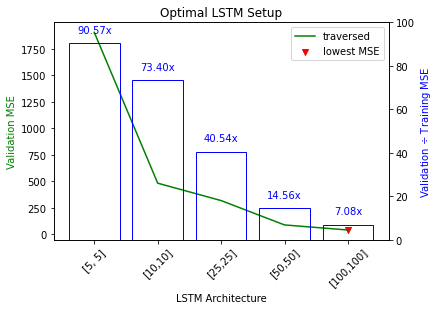

In [295]:
# Figure 3

from matplotlib.pyplot import text

x = list(res_try_d_0[1].keys())
y1 = [res_try_d_0[1][row][0] for row in list(res_try_d_0[1].keys())]
y2 = np.array(y1)/np.array([res_try_d_0[1][row][1] for row in list(res_try_d_0[1].keys())])

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1,'g-',label='traversed')
ax1.scatter(x[-1],y1[-1],color='r',label='lowest MSE',marker = 'v')
ax2.bar(x, y2,fill=False,edgecolor='b')

ax1.set_title('Optimal LSTM Setup')
ax1.set_xlabel('LSTM Architecture')
ax1.set_ylabel('Validation MSE',color='g')
ax2.set_ylabel('Validation $\div$ Training MSE',color='b')

for x,y in zip(x,y2):

    label = "{:.2f}x".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 color='b')

ax1.set_xticklabels(['[5, 5]','[10,10]','[25,25]','[50,50]','[100,100]'], rotation=45)
ax1.legend()
ax2.set_ylim([0,100])

plt.show()

C:\Users\13127\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)
C:\Users\13127\anaconda3\lib\site-packages\seaborn\distributions.py:2551: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `kdeplot` (an axes-level function for kernel density plots).
  warnings.warn(msg, FutureWarning)


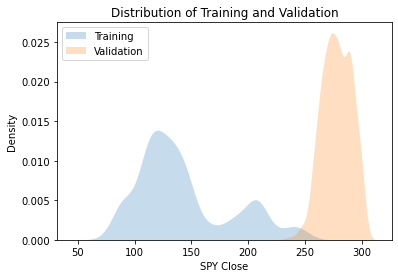

In [1038]:
# Figure 4
import seaborn as sns

sns.distplot(train_tune['Close'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 0}, 
                  label = 'Training')

sns.distplot(train_valid['Close'], hist = False, kde = True,
                 kde_kws = {'shade': True, 'linewidth': 0}, 
                  label = 'Validation')

plt.title('Distribution of Training and Validation')
plt.xlabel('SPY Close')
plt.legend(loc='upper left')

<ipython-input-299-a73aa0b21b6b>:32: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['[5, 5]','[10,10]','[25,25]','[50,50]','[100,100]'], rotation=45)


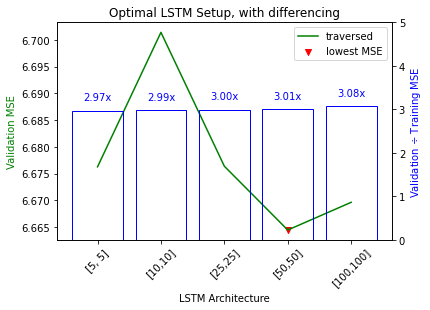

In [299]:
# Figure 5

from matplotlib.pyplot import text

x = list(res_try_d_1[1].keys())
y1 = [res_try_d_1[1][row][0] for row in list(res_try_d_1[1].keys())]
y2 = np.array(y1)/np.array([res_try_d_1[1][row][1] for row in list(res_try_d_1[1].keys())])

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1,'g-',label='traversed')
ax1.scatter(x[-2],y1[-2],color='r',label='lowest MSE',marker = 'v')
ax2.bar(x, y2,fill=False,edgecolor='b')

ax1.set_title('Optimal LSTM Setup, with differencing')
ax1.set_xlabel('LSTM Architecture')
ax1.set_ylabel('Validation MSE',color='g')
ax2.set_ylabel('Validation $\div$ Training MSE',color='b')

for x,y in zip(x,y2):

    label = "{:.2f}x".format(y)

    plt.annotate(label, # this is the text
                 (x,y), # these are the coordinates to position the label
                 textcoords="offset points", # how to position the text
                 xytext=(0,10), # distance from text to points (x,y)
                 ha='center',
                 color='b')

ax1.set_xticklabels(['[5, 5]','[10,10]','[25,25]','[50,50]','[100,100]'], rotation=45)
ax1.legend()
ax2.set_ylim([0,5])

plt.show()

<ipython-input-308-8600061a61f5>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['[5, 5]','[10,10]','[25,25]','[50,50]','[100,100]'], rotation=45)


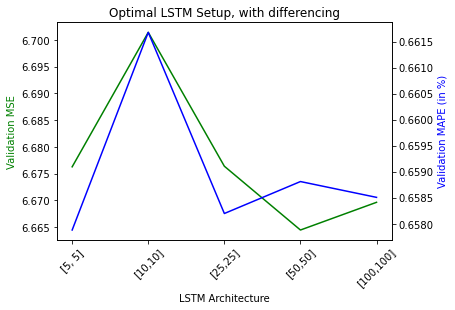

In [308]:
# Figure 6

from matplotlib.pyplot import text

x = list(res_try_d_1[1].keys())
y1 = [res_try_d_1[1][row][0] for row in list(res_try_d_1[1].keys())]
y2 = [res_try_d_1[1][row][2] for row in list(res_try_d_1[1].keys())]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1,'g-')
ax2.plot(x, y2,'b-')

ax1.set_title('Optimal LSTM Setup, with differencing')
ax1.set_xlabel('LSTM Architecture')
ax1.set_ylabel('Validation MSE',color='g')
ax2.set_ylabel('Validation MAPE (in %)',color='b')

ax1.set_xticklabels(['[5, 5]','[10,10]','[25,25]','[50,50]','[100,100]'], rotation=45)

plt.show()

<ipython-input-86-ecf3254ce5ca>:20: UserWarning: FixedFormatter should only be used together with FixedLocator
  ax1.set_xticklabels(['n=128,w=5','n=256,w=5','n=512,w=5','n=128,w=10','n=256,w=10','n=512,w=10'], rotation=45)


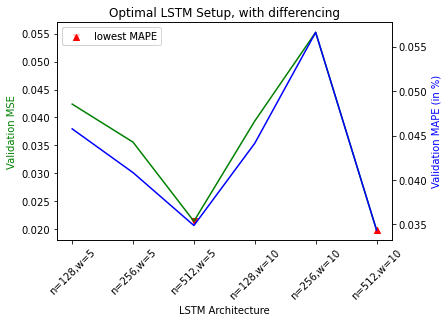

In [86]:
# Figure 6

from matplotlib.pyplot import text

x = list(res_d_1_all[1].keys())
y1 = [res_d_1_all[1][row][0] for row in list(res_d_1[1].keys())]
y2 = [res_d_1_all[1][row][2] for row in list(res_d_1[1].keys())]

fig, ax1 = plt.subplots()

ax2 = ax1.twinx()
ax1.plot(x, y1,'g-')
ax2.plot(x, y2,'b-')

ax1.set_title('Optimal LSTM Setup, with differencing')
ax1.set_xlabel('LSTM Architecture')
ax1.set_ylabel('Validation MSE',color='g')
ax2.set_ylabel('Validation MAPE (in %)',color='b')

ax1.set_xticklabels(['n=128,w=5','n=256,w=5','n=512,w=5','n=128,w=10','n=256,w=10','n=512,w=10'], rotation=45)

ax1.scatter(x[2],y1[2],color='r',label='lowest MSE',marker = 'v')
ax2.scatter(x[-1],y2[-1],color='r',label='lowest MAPE',marker = '^')

ax1.legend()
ax2.legend()
plt.show()

In [321]:
res_check = []
for i in np.linspace(0.1,0.5,5):
    res_check.append(auto_LSTM(train_tune, train_valid,[[100,100]], d = 1,only_val=False,drop_rate=i))

training:[100, 100] window_size=100
Epoch 1/5
137/137 [==============================] - 40s 274ms/step - loss: 2.1831 - mean_squared_error: 2.1831
Epoch 2/5
137/137 [==============================] - 40s 295ms/step - loss: 2.1762 - mean_squared_error: 2.1762
Epoch 3/5
137/137 [==============================] - 38s 278ms/step - loss: 2.1783 - mean_squared_error: 2.1783
Epoch 4/5
137/137 [==============================] - 36s 266ms/step - loss: 2.1738 - mean_squared_error: 2.1738
Epoch 5/5
16/16 [==============================] - 1s 52ms/step
[100, 100] window_size=100 train_score: 2.1668925556065304
[100, 100] window_size=100 val_score: 6.684067995665666
training:[100, 100] window_size=100
Epoch 1/5
137/137 [==============================] - 40s 271ms/step - loss: 2.1841 - mean_squared_error: 2.1841
Epoch 2/5
137/137 [==============================] - 37s 272ms/step - loss: 2.1798 - mean_squared_error: 2.1798
Epoch 3/5
137/137 [==============================] - 37s 270ms/step - loss: 2

In [398]:
# Base final models ARMA
arma_pred = []
arma_miss = []

for i in range(len(test)):
    use_data = list(train['Close'][i:]) + list(test['Close'][0:i])
    
    curr_model = ARIMA(use_data, order=(2,1,0))
    curr_model_fit = curr_model.fit()
    
    arma_pred.append(curr_model_fit.forecast())
    arma_miss.append(curr_model_fit.forecast() - list(test['Close'])[i])

<ipython-input-398-0f27f2825ec7>:6: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  use_data = list(train['Close'][i:]) + list(test['Close'][0:i])


<ipython-input-470-6012ddefd26b>:1: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(test['Date'][-20:],test['Close'][-20:],label='True',alpha=0.25)
<ipython-input-470-6012ddefd26b>:2: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-based* indexing, consistent with e.g. `series[i]` lookups. To retain the old behavior, use `series.iloc[i:j]`. To get the future behavior, use `series.loc[i:j]`.
  plt.plot(test['Date'][-20:],arma_pred[-20:],label='ARMA',linewidth=2)
<ipython-input-470-6012ddefd26b>:3: FutureWarning: The behavior of `series[i:j]` with an integer-dtype index is deprecated. In a future version, this will be treated as *label-b

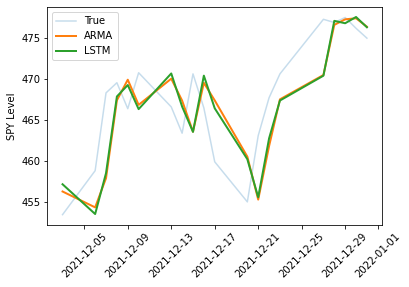

In [470]:
plt.plot(test['Date'][-20:],test['Close'][-20:],label='True',alpha=0.25)
plt.plot(test['Date'][-20:],arma_pred[-20:],label='ARMA',linewidth=2)
plt.plot(test['Date'][-20:],LSTM_pred[-20:],label='LSTM',linewidth=2)

plt.ylabel('SPY Level')
plt.xticks(rotation=45)
plt.legend()

In [423]:
# Base final models LSTM

h = 1
num_neurons = window = 50


use_data = list(np.diff(SPY_df['Close']))

X, Y = windowing(use_data[:(len(train.reset_index()['Close'])-1)], window)

use_test = use_data[-(len(test.reset_index()['Close']) + window):]
X_test, Y_test = windowing(use_test, window)

curr_model = keras.Sequential()

curr_model.add(layers.LSTM(num_neurons, input_shape=(window, h),return_sequences=False))

curr_model.add(layers.Dense(1))
curr_model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

curr_model.fit(X, Y, epochs=epochs_size)                

Epoch 1/5
155/155 [==============================] - 8s 39ms/step - loss: 2.6862 - mean_squared_error: 2.6862
Epoch 2/5
155/155 [==============================] - 6s 38ms/step - loss: 2.6760 - mean_squared_error: 2.6760
Epoch 3/5
155/155 [==============================] - 6s 38ms/step - loss: 2.6741 - mean_squared_error: 2.6741
Epoch 4/5
155/155 [==============================] - 6s 38ms/step - loss: 2.6726 - mean_squared_error: 2.6726
Epoch 5/5
155/155 [==============================] - 6s 38ms/step - loss: 2.6725 - mean_squared_error: 2.6725


In [469]:
LSTM_pred = np.array([i[0] for i in (curr_model.predict(X_test))] + np.array([list(train.reset_index()['Close'])[-1]] + list(test.reset_index()['Close'])[:-1]))

18/18 [==============================] - 1s 18ms/step


In [471]:
np.mean((LSTM_pred - test['Close'])**2)

21.514960853558357

In [479]:
np.mean(([i[0] for i in arma_pred] - test['Close'])**2)

21.533895209690723

In [476]:
np.mean(abs(np.array([i[0] for i in arma_pred] - test['Close']))/abs(np.array(test['Close'])))*100

0.9199881390848741

In [475]:
np.mean(abs(np.array(LSTM_pred - test['Close']))/abs(np.array(test['Close'])))*100

0.9219809401026945

In [456]:
train.iloc[99]

Date         2000-05-24 00:00:00
Open                       138.0
High                    140.6875
Low                        136.5
Close                     140.25
Adj Close              92.566017
Volume                  11081500
Name: 99, dtype: object

In [517]:
# reduced data

res_dt = {}

for k in range(10):
    
    takeout = k*100

    arma_pred = []
    
    train_use = train.iloc[takeout:]

    for j in range(len(test)):
        use_data = list(train_use['Close'][j:]) + list(test['Close'][0:j])

        curr_model = ARIMA(use_data, order=(2,1,0))
        curr_model_fit = curr_model.fit()

        arma_pred.append(float(curr_model_fit.forecast()))

    h = 1
    num_neurons = window = 50
    
    new_agg = pd.concat([train_use,test])
    use_data = list(np.diff(new_agg['Close']))

    X, Y = windowing(use_data[:(len(train_use.reset_index()['Close'])-1)], window)

    use_test = use_data[-(len(test.reset_index()['Close']) + window):]
    X_test, Y_test = windowing(use_test, window)

    curr_model = keras.Sequential()

    curr_model.add(layers.LSTM(num_neurons, input_shape=(window, h),return_sequences=False))

    curr_model.add(layers.Dense(1))
    curr_model.compile(optimizer='adam', loss='mse', metrics=['mean_squared_error'])

    curr_model.fit(X, Y, epochs=epochs_size)
    
    LSTM_pred = np.array([i[0] for i in (curr_model.predict(X_test))] + np.array([list(train_use.reset_index()['Close'])[-1]] + list(test.reset_index()['Close'])[:-1]))
    
    arma_miss = np.mean(np.array(arma_pred - np.array(list(test['Close'])))**2)
    LSTM_miss = np.mean((LSTM_pred - list(test['Close']))**2)
    
    arma_mape = np.mean(abs(np.array(arma_pred - test['Close']))/abs(np.array(test['Close'])))*100
    LSTM_mape = np.mean(abs(np.array(LSTM_pred - test['Close']))/abs(np.array(test['Close'])))*100
    
    print(k)
    res_dt[k] = [arma_miss,LSTM_miss,arma_mape,LSTM_mape]

Epoch 1/5
155/155 [==============================] - 7s 33ms/step - loss: 2.6858 - mean_squared_error: 2.6858
Epoch 2/5
155/155 [==============================] - 5s 33ms/step - loss: 2.6798 - mean_squared_error: 2.6798
Epoch 3/5
155/155 [==============================] - 5s 34ms/step - loss: 2.6754 - mean_squared_error: 2.6754
Epoch 4/5
155/155 [==============================] - 5s 33ms/step - loss: 2.6747 - mean_squared_error: 2.6747
Epoch 5/5
18/18 [==============================] - 1s 12ms/step
0
Epoch 1/5
151/151 [==============================] - 8s 40ms/step - loss: 2.6411 - mean_squared_error: 2.6411
Epoch 2/5
151/151 [==============================] - 6s 40ms/step - loss: 2.6389 - mean_squared_error: 2.6389
Epoch 3/5
151/151 [==============================] - 6s 40ms/step - loss: 2.6371 - mean_squared_error: 2.6371
Epoch 4/5
151/151 [==============================] - 6s 39ms/step - loss: 2.6323 - mean_squared_error: 2.6323
Epoch 5/5
18/18 [==============================] - 1s 